In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.set()

def strip(x):
    return x.replace('\t','')

global_df = pd.read_pickle('global_data.pkl')
country_dick = pd.read_pickle('country_data.pkl')
country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

country_death_rate = pd.read_csv('deaths_per_year.csv',sep=';',
                                 header=None,names=['country','deaths_per_thousand'],index_col=0,usecols=[1,2])

country_death_rate.sort_index(inplace=True)
world_pop = 7.8e9
global_deaths_per_year = 56e6
global_deaths_per_day = 56e6 / 365

population_data =  country_populations.join(country_death_rate,how='outer')



cant find Bahamas in population data
cant find Congo (Brazzaville) in population data
cant find Congo (Kinshasa) in population data
cant find Diamond Princess in population data
cant find West Bank and Gaza in population data
cant find Kosovo in population data
cant find MS Zaandam in population data


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


count    101.000000
mean       5.016089
std        9.027805
min        0.006502
25%        0.431604
50%        1.156149
75%        5.025973
max       43.923120
dtype: float64

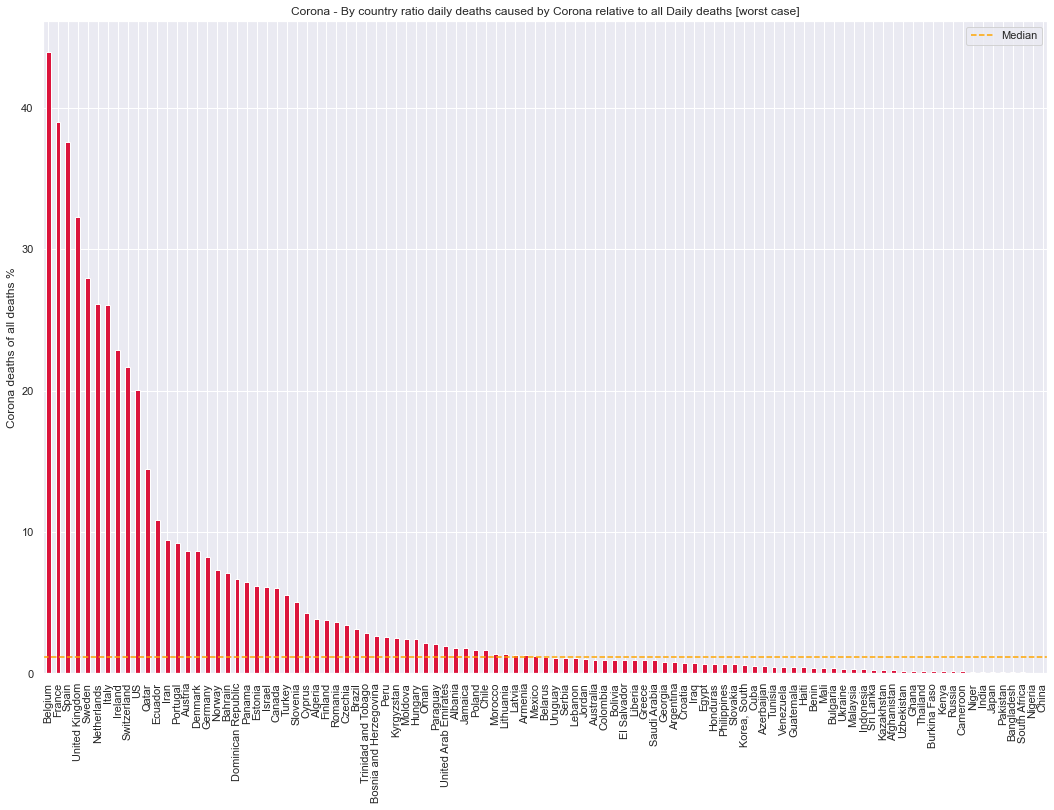

In [2]:
def plot_country(country_name):
    country = country_dick[country_name]
    country_pop = population_data.loc[country_name,'population']
    country_death_rate = population_data.loc[country_name,'deaths_per_thousand'] / 1000 / 365
    country_deaths_per_day = country_death_rate * country_pop

    if country_pop > 1e6: #skip lilleput-countries
        
        mask = (1e6 * country['confirmed'] / country_pop) > 1
        country = country[mask]
        mask = country['dead_inc'] >= 1
        country = country[mask]
    
        
        country_deaths_by_corona_per_day = country['dead_inc']
        country_total_deaths_per_day =  country_deaths_per_day + country_deaths_by_corona_per_day
        ratio = country_deaths_by_corona_per_day / country_total_deaths_per_day
    
        return pd.Series(ratio,name=country_name)

death_ratio_df = pd.DataFrame()

for c in country_dick.keys():
    
    try:
        pop = population_data.loc[c] #test if present in world_population.csv
        s = plot_country(c)
        death_ratio_df = pd.concat([death_ratio_df,s],axis=1)
    except KeyError:
        print ('cant find {} in population data'.format(c))

death_ratio_df.index = pd.DatetimeIndex(death_ratio_df.index).date
mask = ~death_ratio_df.isnull().all()
df = death_ratio_df.loc[:,mask].T
last_days_status = df.iloc[:,-4:].median(axis=1)
last_days_status = last_days_status.sort_values(ascending=False)
last_days_status.dropna(inplace=True)
last_days_status *= 100


plt.figure(figsize=(18,12))
plt.title('Corona - By country ratio daily deaths caused by Corona relative to all Daily deaths [worst case]')
plt.ylabel('Corona deaths of all deaths %')
plt.axhline(last_days_status.median() , color='orange',ls='dashed',label='Median')
plt.legend (loc='upper left')


plt.savefig('corona_corona_death_ratio.jpg',format='jpg')
last_days_status.plot(kind='bar',color='crimson') #exclude San Marino
plt.savefig('corona_death_percentage.jpg',format='jpg')
last_days_status.describe()



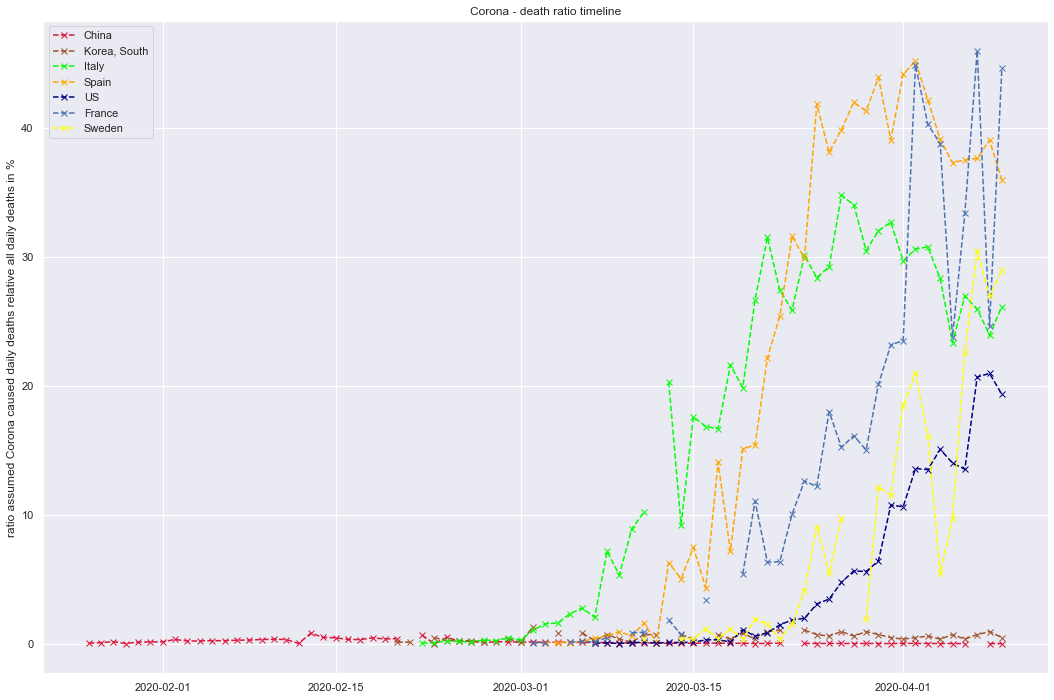

In [3]:
some_countries = ['China','Korea, South','Italy','Spain','US','France','Sweden']
colors = ['crimson','sienna','lime','orange','navy','b','yellow']

plt.figure(figsize=(18,12))
for i,c in enumerate(some_countries):
    country = df.loc[c] * 100
    plt.plot(country,'x--',label=c,color=colors[i])

plt.title('Corona - death ratio timeline')
plt.ylabel('ratio assumed Corona caused daily deaths relative all daily deaths in %')
plt.legend(loc='upper left')
plt.savefig('corona_death_ratio.jpg',format='jpg')

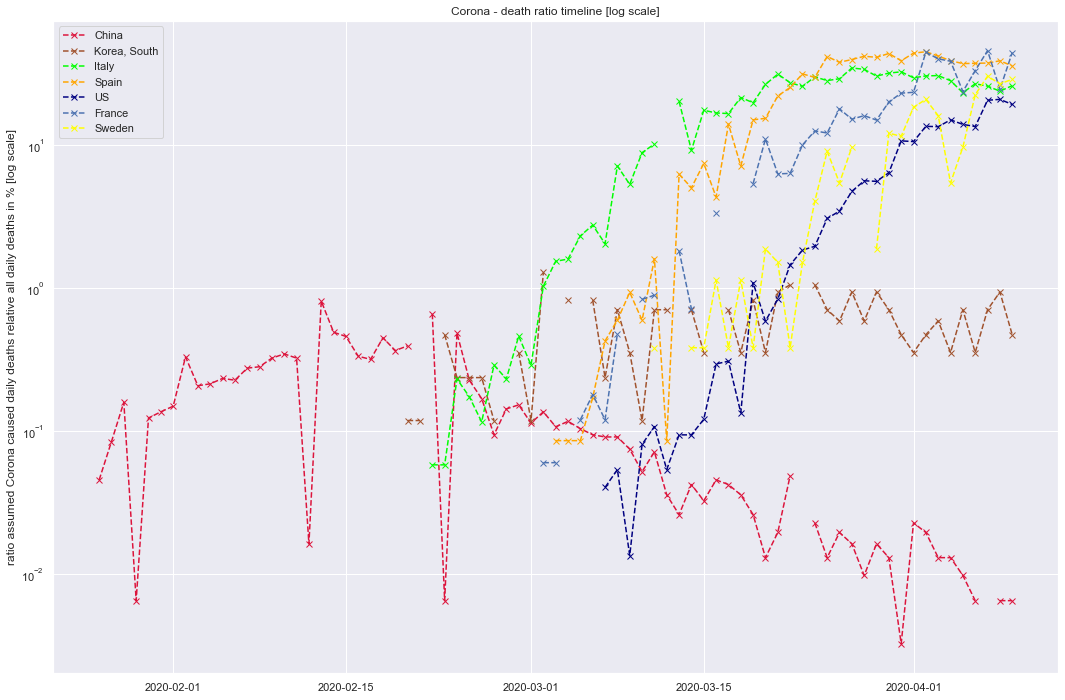

In [4]:
plt.figure(figsize=(18,12))
for i,c in enumerate(some_countries):
    country = df.loc[c] * 100
    plt.plot(country,'x--',label=c,color=colors[i])

plt.title('Corona - death ratio timeline [log scale]')
plt.ylabel('ratio assumed Corona caused daily deaths relative all daily deaths in % [log scale]')
plt.legend(loc='upper left')
plt.yscale('log')
plt.savefig('corona_death_ratio_log.jpg',format='jpg')